## DocuMind
Tool which takes documents as inputs and answers questions about them based on their content and the LLM's knowledge.

## SetUp

Install the dependencies you need to run the notebook.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.jp-OutputArea-output { max-height: none; }</style>"))

C:\Users\ASUSS\AppData\Local\Temp\ipykernel_14124\77354648.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [1]:
# for linux
# !apt-get install poppler-utils tesseract-ocr libmagic-dev

# for mac
# !brew install poppler tesseract libmagic

In [2]:
%pip install -Uq "unstructured[all-docs]" pillow lxml pillow
%pip install -Uq chromadb tiktoken
%pip install -Uq langchain langchain-community langchain-openai langchain-groq
%pip install -Uq python_dotenv

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-ai-generativelanguage 0.4.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.29.5 which is incompatible.
streamlit 1.37.1 requires pillow<11,>=7.1.0, but you have pillow 11.2.1 which is incompatible.


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os

# keys for the services we will use

os.environ["GENAI_API_KEY"] = "enter key here"
os.environ["GROQ_API_KEY"] = "enter key here"
os.environ["LANGCHAIN_API_KEY"] = "enter key here"
os.environ["LANGCHAIN_TRACING_V2"] = "true"


## Extract the data

Extract the elements of the PDF that we will be able to use in the retrieval process. These elements can be: Text, Images, Tables, etc.

### Partition PDF tables, text, and images

In [ ]:
##multiple files
import os
import glob
from pathlib import Path
from unstructured.partition.auto import partition

# Option 1: Process all files in a directory with specific extensions
def get_files_from_directory(directory_path, extensions=['.pdf', '.docx', '.pptx']):
    """Get all files with specific extensions from a directory"""
    files = []
    for ext in extensions:
        files.extend(glob.glob(f"{directory_path}/*{ext}"))
    return files
file_paths = get_files_from_directory("./data")

In [ ]:
from unstructured.partition.auto import partition

In [6]:
def process_documents(file_paths):
    """Process multiple documents and combine their chunks"""
    all_chunks = []
    file_sources = {}  # Track which file each chunk came from
    
    for file_path in file_paths:
        print(f"Processing {file_path}...")
        file_extension = os.path.splitext(file_path)[1].lower()
        
        # Process each file
        file_chunks = partition(
            filename=file_path,
            chunking_strategy="by_title",
            max_characters=10000,
            combine_text_under_n_chars=2000,
            new_after_n_chars=6000,
            infer_table_structure=True,
            strategy="hi_res",
            extract_image_block_types=["Image"],
            extract_image_block_to_payload=True,
        )
        
        # Add source information to each chunk's metadata
        for chunk in file_chunks:
            if not hasattr(chunk.metadata, 'source'):
                chunk.metadata.source = file_path
        
        # Add to combined list
        all_chunks.extend(file_chunks)
        
        # Track which file these chunks came from
        file_sources[file_path] = len(file_chunks)
        
    print(f"Processed {len(file_paths)} files, extracted {len(all_chunks)} total chunks")
    return all_chunks, file_sources

# Process all files
chunks, file_sources = process_documents(file_paths)

Processing ./data\Learning about risk Machine learning for risk assessment.pdf...


The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


Processing ./data\Machine_Learning_Applications_in_Industry_Safety_Analysis_and_Prediction_of_Industrial_Accidents (1).pdf...
Processed 2 files, extracted 32 total chunks


In [ ]:
##single file
import os
from unstructured.partition.auto import partition

file_path = "Part1 TOPOLOGYS AND TRANSMISSION MEDIA.pdf"

# Get the file extension to use the appropriate partition function
file_extension = os.path.splitext(file_path)[1].lower()

# Reference: https://docs.unstructured.io/open-source/core-functionality/chunking
chunks = partition(
    filename=file_path,
    # Common parameters for all document types
    chunking_strategy="by_title",          # or 'basic'
    max_characters=10000,                  # defaults to 500
    combine_text_under_n_chars=2000,       # defaults to 0
    new_after_n_chars=6000,
    
    # Parameters for structured docs (PDF, PPTX, DOCX)
    infer_table_structure=True,            # extract tables
    strategy="hi_res",                     # mandatory to infer tables
    
    # Image extraction options
    extract_image_block_types=["Image"],   # Add 'Table' to list to extract image of tables
    extract_image_block_to_payload=True,   # if true, will extract base64 for API usage
)

In [7]:
# We get 2 types of elements from the partition_pdf function
set([str(type(el)) for el in chunks])

{"<class 'unstructured.documents.elements.CompositeElement'>"}

In [10]:
# Each CompositeElement containes a bunch of related elements.
# This makes it easy to use these elements together in a RAG pipeline.

chunks[0].metadata.orig_elements

In [11]:
# This is what an extracted image looks like.
# It contains the base64 representation only because we set the param extract_image_block_to_payload=True

elements = chunks[0].metadata.orig_elements
chunk_images = [el for el in elements if 'Image' in str(type(el))]
chunk_images[0].to_dict()

{'type': 'Image',
 'element_id': 'a842f922-b6ce-4234-83da-22a80bb2667f',
 'text': 'LSEVIER',
 'metadata': {'coordinates': {'points': ((104.56694444444445,
     168.81972222222208),
    (104.56694444444445, 349.92222222222216),
    (269.6063888888889, 349.92222222222216),
    (269.6063888888889, 168.81972222222208)),
   'system': 'PixelSpace',
   'layout_width': 1654,
   'layout_height': 2205},
  'last_modified': '2025-06-04T12:20:41',
  'filetype': 'PPM',
  'languages': ['eng'],
  'page_number': 1,
  'image_base64': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAC1AKUDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDx

### Separate extracted elements into tables, text, and images

In [ ]:
##for multiple files, uses metadata to track source
# Each chunk has metadata that includes the source file path

# Update the separation functions to include source information
def separate_elements(chunks):
    """Separate chunks into tables, texts, and images with source tracking"""
    tables = []
    texts = []
    
    for chunk in chunks:
        if "CompositeElement" in str(type(chunk)):
            for element in chunk.metadata.orig_elements:
                if "Table" in str(type(element)):
                    # Add source information if not already present
                    if hasattr(chunk.metadata, 'source'):
                        element.metadata.source = chunk.metadata.source
                    tables.append(element)
            texts.append(chunk)
    
    return texts, tables

# Update image extraction to track sources
def get_images_base64(chunks):
    """Get images with source information"""
    images_with_metadata = []
    
    for chunk in chunks:
        if "CompositeElement" in str(type(chunk)):
            chunk_els = chunk.metadata.orig_elements
            for el in chunk_els:
                if "Image" in str(type(el)):
                    source = chunk.metadata.source if hasattr(chunk.metadata, 'source') else "unknown"
                    images_with_metadata.append({
                        "base64": el.metadata.image_base64,
                        "source": source
                    })
    
    return images_with_metadata

# Extract elements
texts, tables = separate_elements(chunks)
images_with_metadata = get_images_base64(chunks)
images = [img["base64"] for img in images_with_metadata]

In [ ]:
#single source file

# separate tables from texts
tables = []
texts = []

for chunk in chunks:
    if "CompositeElement" in str(type(chunk)):  # Check if it's a CompositeElement
        for element in chunk.metadata.orig_elements:  # Iterate through its elements
            if "Table" in str(type(element)):  # Now check for Table type
                tables.append(element)  # Append the table element
        texts.append(chunk)  # Still append the CompositeElement to texts

In [59]:
# Get the images from the CompositeElement objects
def get_images_base64(chunks):
    images_b64 = []
    for chunk in chunks:
        if "CompositeElement" in str(type(chunk)):
            chunk_els = chunk.metadata.orig_elements
            for el in chunk_els:
                if "Image" in str(type(el)):
                    images_b64.append(el.metadata.image_base64)
    return images_b64

images = get_images_base64(chunks)

In [13]:
tables

In [14]:
images

['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAC1AKUDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD37NZV1r0NjNPHc29wnlDcH2hg6n+IYJOM8E4+XqcDmsLXTpj6pNNax291foQskUmGBcYxtwDIHA6bOPX2pPBqep3MdjJi4YCR2guGcxRhSvG/kOyk8EjruG5tpwAdPpupSf2A81w32i7tIytxsABd1QNkDoNwKsO3zCp5tc

In [15]:
texts

#### Check what the images look like

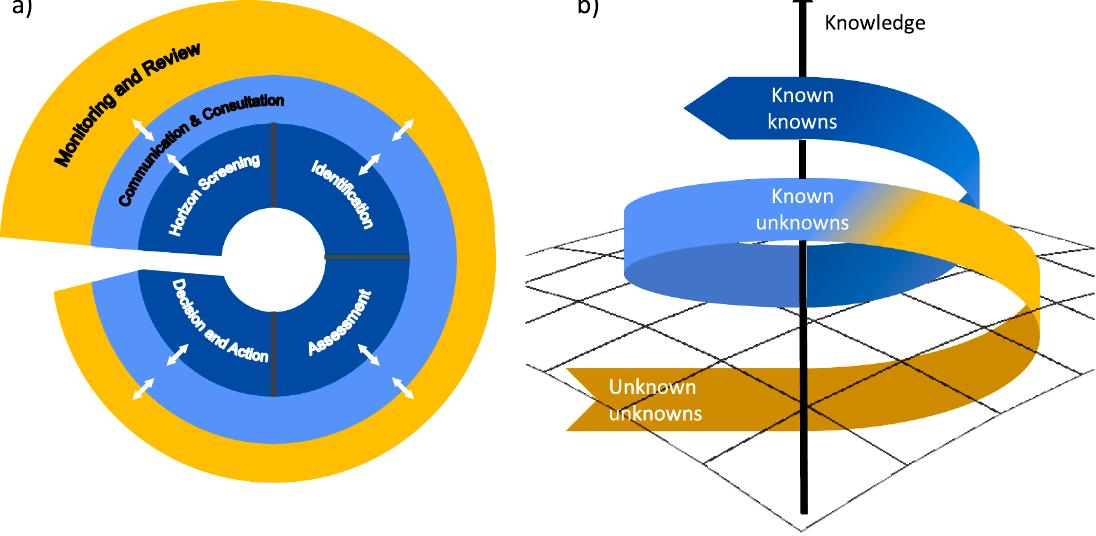

In [19]:
import base64
from IPython.display import Image, display

def display_base64_image(base64_code):
    # Decode the base64 string to binary
    image_data = base64.b64decode(base64_code)
    # Display the image
    display(Image(data=image_data))

display_base64_image(images[4])

## Summarize the data

Create a summary of each element extracted from the PDF. This summary will be vectorized and used in the retrieval process.

### Text and Table summaries


In [20]:
%pip install -Uq langchain-groq

Note: you may need to restart the kernel to use updated packages.


In [21]:
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

In [22]:
# Prompt
prompt_text = """
You are an assistant tasked with summarizing tables and text.
Give a concise summary of the table or text.

Respond only with the summary, no additionnal comment.
Do not start your message by saying "Here is a summary" or anything like that.
Just give the summary as it is.

Table or text chunk: {element}

"""
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
model = ChatGroq(temperature=0.5, model="llama-3.1-8b-instant")
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

In [21]:
tables 

In [ ]:
##use this for multiple files
##fast summarization + rate limiting
import time
import asyncio
import random
from typing import List, Any, Dict
from concurrent.futures import ThreadPoolExecutor
from functools import partial

# Optimized batch processing with adaptive rate limiting
def process_with_adaptive_rate_limiting(chain, items, batch_size=5, max_concurrency=2):
    """Process items with adaptive rate limiting to maximize throughput"""
    results = []
    times = []  # Track API response times to adapt
    
    # Initial backoff parameters
    min_delay = 0.2
    current_delay = 0.5
    
    with ThreadPoolExecutor(max_workers=max_concurrency) as executor:
        for i in range(0, len(items), batch_size):
            batch = items[i:i + batch_size]
            print(f"Processing batch {i//batch_size + 1}/{(len(items) + batch_size - 1)//batch_size}")
            
            try:
                # Time the API call
                start = time.time()
                batch_results = chain.batch(batch, {"max_concurrency": 1})
                end = time.time()
                
                # Successful call - adjust delay based on response time
                elapsed = end - start
                times.append(elapsed)
                
                # If we have at least 3 data points, adapt our delay
                if len(times) >= 3:
                    avg_time = sum(times[-3:]) / 3
                    # Gradually reduce delay if things are going well
                    current_delay = max(min_delay, current_delay * 0.9)
                
                results.extend(batch_results)
                
            except Exception as e:
                if "rate_limit" in str(e).lower():
                    print(f"Rate limit hit: {e}")
                    # Increase delay on rate limit errors
                    current_delay = min(current_delay * 2, 5.0)
                    time.sleep(current_delay)
                    
                    # Retry with smaller batch size
                    smaller_batch_size = max(1, batch_size // 2)
                    print(f"Retrying with smaller batch size: {smaller_batch_size}")
                    
                    # Process the failed batch with smaller size
                    for j in range(0, len(batch), smaller_batch_size):
                        mini_batch = batch[j:j + smaller_batch_size]
                        try:
                            mini_results = chain.batch(mini_batch, {"max_concurrency": 1})
                            results.extend(mini_results)
                            time.sleep(current_delay)
                        except Exception as e2:
                            print(f"Failed even with smaller batch: {e2}")
                            results.extend(["Failed to summarize due to persistent rate limits"] * len(mini_batch))
                else:
                    print(f"Non-rate limit error: {e}")
                    results.extend(["Failed to summarize due to error"] * len(batch))
            
            # Add a dynamic delay between batches
            if i + batch_size < len(items):
                print(f"Waiting {current_delay:.2f}s before next batch...")
                time.sleep(current_delay)
                
    return results

# Process text summaries - start with larger batches for speed
print(f"Processing {len(texts)} text elements...")
text_summaries = process_with_adaptive_rate_limiting(
    summarize_chain, 
    texts,
    batch_size=5,  # Start with larger batches
    max_concurrency=2  # Try slightly higher concurrency
)

# Process table summaries - tables may be smaller, so try larger batches
print(f"Processing {len(tables)} table elements...")
tables_html = [table.metadata.text_as_html for table in tables]
table_summaries = process_with_adaptive_rate_limiting(
    summarize_chain,
    tables_html,
    batch_size=5,
    max_concurrency=2
)

Processing 32 text elements...
Processing batch 1/7
Waiting 0.50s before next batch...
Processing batch 2/7
Waiting 0.50s before next batch...
Processing batch 3/7
Waiting 0.45s before next batch...
Processing batch 4/7
Waiting 0.41s before next batch...
Processing batch 5/7
Waiting 0.36s before next batch...
Processing batch 6/7
Waiting 0.33s before next batch...
Processing batch 7/7
Processing 7 table elements...
Processing batch 1/2
Waiting 0.50s before next batch...
Processing batch 2/2


In [24]:
import time
import random
from typing import List, Any, Dict, Optional
from tenacity import (
    retry,
    stop_after_attempt,
    wait_exponential,
    retry_if_exception_type
)

# Define a function to handle rate limits with retries
@retry(
    retry=retry_if_exception_type((Exception)),  # Retry on exceptions
    wait=wait_exponential(multiplier=1, min=2, max=60),  # Exponential backoff
    stop=stop_after_attempt(5),  # Stop after 5 attempts
)
def process_batch_with_retry(chain, batch_items, batch_size=5, concurrency=2):
    """Process items in smaller batches with retry logic for rate limits"""
    try:
        return chain.batch(batch_items, {"max_concurrency": concurrency})
    except Exception as e:
        if "rate_limit" in str(e).lower():
            print(f"Rate limit hit, waiting before retry: {e}")
            # Add randomness to avoid thundering herd problem
            time.sleep(random.uniform(5, 10))
            raise e  # Re-raise to trigger retry
        else:
            raise  # Re-raise if not a rate limit error

def process_items_in_small_batches(chain, items, batch_size=5, concurrency=1):
    """Process a list of items in small batches to avoid rate limits"""
    results = []
    for i in range(0, len(items), batch_size):
        batch = items[i:i + batch_size]
        print(f"Processing batch {i//batch_size + 1}/{(len(items) + batch_size - 1)//batch_size}")
        
        try:
            batch_results = process_batch_with_retry(chain, batch, batch_size, concurrency)
            results.extend(batch_results)
        except Exception as e:
            print(f"Failed to process batch after retries: {e}")
            # Add placeholders for failed items to maintain alignment
            results.extend(["Failed to summarize due to rate limits"] * len(batch))
            
        # Add a small delay between batches
        if i + batch_size < len(items):
            delay = random.uniform(0.5, 2.0)
            print(f"Waiting {delay:.2f}s before next batch...")
            time.sleep(delay)
            
    return results

# Install tenacity if needed
# %pip install -Uq tenacity

# Now use the rate-limited processing for both texts and tables
print(f"Processing {len(texts)} text elements...")
text_summaries = process_items_in_small_batches(
    summarize_chain, 
    texts,
    batch_size=3,  # Process just 3 at a time
    concurrency=1   # Only 1 concurrent request
)

print(f"Processing {len(tables)} table elements...")
tables_html = [table.metadata.text_as_html for table in tables]
table_summaries = process_items_in_small_batches(
    summarize_chain,
    tables_html,
    batch_size=2,  # Process just 2 at a time
    concurrency=1  # Only 1 concurrent request
)

Processing 32 text elements...
Processing batch 1/11
Waiting 1.83s before next batch...
Processing batch 2/11
Waiting 1.59s before next batch...
Processing batch 3/11
Waiting 1.92s before next batch...
Processing batch 4/11
Waiting 1.36s before next batch...
Processing batch 5/11
Waiting 0.64s before next batch...
Processing batch 6/11
Waiting 1.05s before next batch...
Processing batch 7/11
Waiting 1.44s before next batch...
Processing batch 8/11
Waiting 1.23s before next batch...
Processing batch 9/11
Waiting 0.56s before next batch...
Processing batch 10/11
Waiting 1.02s before next batch...
Processing batch 11/11
Processing 7 table elements...
Processing batch 1/4
Waiting 1.72s before next batch...
Processing batch 2/4
Waiting 1.66s before next batch...
Processing batch 3/4
Waiting 0.73s before next batch...
Processing batch 4/4


In [ ]:
#single file
# Summarize text
text_summaries = summarize_chain.batch(texts, {"max_concurrency": 3})

# Summarize tables
tables_html = [table.metadata.text_as_html for table in tables]
table_summaries = summarize_chain.batch(tables_html, {"max_concurrency": 3})

In [32]:
table_summaries

['The table categorizes events into four types: unknown unknowns (unaware of unknowns), known unknowns (aware of unknowns but not risk), unknown knowns (unaware of knowns), and known knowns (aware of knowns with manageable risk).',
 'The table describes the transformation of wellhead damage frequency values into risk increase or decrease based on certain conditions (dra > g aa & and es < 0).',
 'A comparison of two machine learning models (DNN and MLR) shows that the DNN model has higher accuracy (83.5%) than the MLR model (82.3%), but the MLR model has higher recall (90.7%) while the DNN model has higher precision (84.1%).',
 "The table compares the effect of different tolerance levels on model predictions, with metrics including true positives (Tp), true negatives (Tn), false positives (Fp), and false negatives (Fn), showing that as tolerance decreases, the model's accuracy and specificity increase, while sensitivity decreases.",
 'The table shows the effect of varying tolerance on t

In [26]:
text_summaries

['A machine learning approach for risk assessment in safety-critical industries is proposed, using a deep neural network to predict outcomes in scenarios such as an Oil & Gas drilling rig drive-off, showing reasonable accuracy but also highlighting the need for careful model selection and customization.',
 'The concept of risk has been defined by Kaplan and Garrick (1981) as R=f(s,p,c), where scenario, probability, and consequence determine risk. Despite this definition, numerous attempts have been made to capture risk in a more meaningful way, but a common agreement remains elusive. To ensure high reliability in risk environments, industrial facilities must define clear rules of operation, provide advanced training, and foster heedful interaction among actors and components.',
 'The study discusses the challenges of risk assessment in high-risk operations, specifically in the offshore Oil & Gas industry, and proposes a solution using machine learning techniques to address issues with 

### Image summaries
I'm using gemini-2.0-flash for the image summaries, but you can use any other model that supports image inputs.

In [27]:
%pip install -Uq langchain_openai

Note: you may need to restart the kernel to use updated packages.


In [28]:
from langchain_openai import ChatOpenAI
import google.generativeai as genai

# Configure API key
genai.configure(api_key=os.getenv("GENAI_API_KEY"))

prompt_template = "Describe the image in detail. For context, the image is part of a research paper explaining the transformers architecture. Be specific about graphs, such as bar plots."

# Initialize model
model = genai.GenerativeModel(model_name="gemini-2.0-flash")

# Summarize each image
image_summaries = []
for img_b64 in images:
    contents = [
        {
            "inline_data": {
                "mime_type": "image/jpeg",
                "data": img_b64
            }
        },
        {
            "text": prompt_template
        }
    ]
    response = model.generate_content(contents)
    image_summaries.append(response.text)


In [33]:
image_summaries

['Here\'s a detailed description of the image:\n\n**Overall Description:**\n\nThe image is a woodcut or engraving, predominantly in black and white, reminiscent of historical scientific illustrations.  It features a complex scene centered around a tree with a banner draped across its branches, accompanied by a figure of a man standing to the right of the tree.\n\n**Elements within the Image:**\n\n1.  **Tree:** The dominant element is a large, leafy tree. The leaves are densely packed and meticulously detailed with fine lines. The branches are somewhat gnarled and asymmetrical, giving the tree a sense of age and character. A vine or snake-like element appears to be wrapped around the trunk.\n\n2.  **Banner/Scroll:** A banner or scroll is draped across the branches of the tree. It has a decorative, flowing shape. Inscribed upon the banner are the words "NON SOLUS."\n\n3.  **Figure of a Man:** Standing to the right of the tree is a figure of a man. He is depicted wearing a long robe or ga

In [35]:
print(image_summaries[3])

Here's a description of the image, focusing on the graphs and elements visible:

**Overall:**

The image presents two diagrams related to risk or consequence analysis. Both diagrams use a color-coded grid system where green represents lower risk, yellow represents medium risk, orange represents high risk, and red represents the highest risk.

**Left Diagram:**

*   This diagram is a 2D risk matrix.
*   It is a grid of colored squares.
*   The squares are arranged in rows and columns. The horizontal and vertical axes are unlabeled.
*   The colors progress from green in the bottom-left corner to red in the top-right corner.

**Right Diagram:**

*   This diagram presents a 3D risk or consequence space.
*   It uses three axes: Consequence, Probability, and Knowledge.
*   The "surface" of the diagram is a grid, again color-coded as with the 2D grid.
*   The surface "bulges" upward, representing higher risk at higher levels of Consequence, Probability, and Knowledge.
*   There's an arrow lab

## Load data and summaries to vectorstore

### Create the vectorstore

In [36]:
%pip install chromadb langchain sentence-transformers

Note: you may need to restart the kernel to use updated packages.


In [37]:
import uuid
from langchain.vectorstores import Chroma
from langchain.storage import InMemoryStore
from langchain.schema.document import Document
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever

# Use a free Hugging Face–based embedding model
hf_embedding = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

# The vectorstore to use to index the child chunks
vectorstore = Chroma(
    collection_name="multi_modal_rag",
    embedding_function=hf_embedding
)

# The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

C:\Users\ASUSS\AppData\Local\Temp\ipykernel_14124\1722244940.py:9: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  hf_embedding = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
C:\Users\ASUSS\AppData\Local\Temp\ipykernel_14124\1722244940.py:12: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(


In [ ]:
from langchain.embeddings import HuggingFaceEmbeddings

hf_embedding = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
sample_vector = hf_embedding.embed_query("Hello, world!")
print(len(sample_vector), sample_vector[:5])


### Load the summaries and link the to the original data

In [38]:
# Add texts with type annotation
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [
    Document(page_content=summary, metadata={id_key: doc_ids[i], "source": texts[i].metadata.source if hasattr(texts[i].metadata, 'source') else "unknown"}) for i, summary in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)
# Store with explicit type information
for doc_id, text_doc in zip(doc_ids, texts):
    retriever.docstore.mset([(doc_id, {"type": "text", "content": text_doc})])

# Add tables (only if they exist)
if tables:
    table_ids = [str(uuid.uuid4()) for _ in tables]
    summary_tables = [
        Document(page_content=summary, metadata={id_key: table_ids[i], "source": texts[i].metadata.source if hasattr(texts[i].metadata, 'source') else "unknown"}) for i, summary in enumerate(table_summaries)
    ]
    retriever.vectorstore.add_documents(summary_tables)
    # Store with explicit type information
    for table_id, table in zip(table_ids, tables):
        retriever.docstore.mset([(table_id, {"type": "table", "content": table})])
else:
    print("No tables found in the document.")

# Add image summaries (only if they exist)
if images:
    img_ids = [str(uuid.uuid4()) for _ in images]
    summary_img = [
        Document(page_content=summary, metadata={id_key: img_ids[i], "source": texts[i].metadata.source if hasattr(texts[i].metadata, 'source') else "unknown"}) for i, summary in enumerate(image_summaries)
    ]
    retriever.vectorstore.add_documents(summary_img)
    # Store with explicit type information
    for img_id, image in zip(img_ids, images):
        retriever.docstore.mset([(img_id, {"type": "image", "content": image})])
else:
    print("No images found in the document.")

### Check retrieval

In [39]:
# Retrieve
docs = retriever.invoke(
    "what is risk matrix?"
)

In [40]:
for doc in docs:
    print(str(doc) + "\n\n" + "-" * 80)

{'type': 'text', 'content': <unstructured.documents.elements.CompositeElement object at 0x000001C1DD076420>}

--------------------------------------------------------------------------------
{'type': 'text', 'content': <unstructured.documents.elements.CompositeElement object at 0x000001C1DE12F5C0>}

--------------------------------------------------------------------------------
{'type': 'image', 'content': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAGXBQEDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcF

## RAG pipeline

In [41]:
%pip install unstructured langchain_core langchain-openai google-generativeai

  Using cached protobuf-4.25.8-cp310-abi3-win_amd64.whl.metadata (541 bytes)
Using cached protobuf-4.25.8-cp310-abi3-win_amd64.whl (413 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
Note: you may need to restart the kernel to use updated packages.


  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opentelemetry-proto 1.33.1 requires protobuf<6.0,>=5.0, but you have protobuf 4.25.8 which is incompatible.
streamlit 1.37.1 requires pillow<11,>=7.1.0, but you have pillow 11.2.1 which is incompatible.


In [ ]:
import base64
from IPython.display import Image, display

In [42]:
from google.generativeai import configure, GenerativeModel
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.runnables import RunnableParallel
from base64 import b64decode
configure(api_key=os.getenv("GENAI_API_KEY"))

def parse_docs(docs):
    """Split documents based on explicit type information"""
    b64 = []
    text = []
    
    for doc in docs:
        if isinstance(doc, dict) and "type" in doc:
            # Use our explicit type annotations
            if doc["type"] == "image":
                b64.append(doc["content"])
            else:  # "text" or "table"
                text.append(doc["content"])
        elif isinstance(doc, str) and doc.startswith(('JVBERi', '/9j/', 'iVBORw', 'R0lGOD', 'UEs')):
            # Fallback for direct base64 images
            b64.append(doc)
        else:
            # Everything else treated as text
            text.append(doc)
            
    return {"images": b64, "texts": text}

def build_gemini_prompt(inputs):
    """Turn parsed docs + question into Gemini-compatible `contents` list."""
    docs_by_type = inputs["context"]
    question = inputs["question"]
    
    # Use .text instead of .page_content for CompositeElements
    text_ctx = ""
    for d in docs_by_type["texts"]:
        # Use the appropriate attribute based on object type
        if hasattr(d, "page_content"):
            text_ctx += d.page_content + "\n\n"
        else:
            text_ctx += d.text + "\n\n"
    
    # Start with text content (proper Gemini format)
    contents = [
        {"text": f"Context:\n{text_ctx}\nQuestion: {question}"}
    ]
    
    # Append images with inline base64 data (proper Gemini format)
    for img_b64 in docs_by_type["images"]:
        contents.append({
            "inline_data": {
                "mime_type": "image/jpeg",
                "data": img_b64
            }
        })
    
    return contents

def gemini_generate(contents):
    """Call Gemini and return raw text."""
    model = GenerativeModel(model_name="gemini-2.0-flash")
    resp = model.generate_content(contents=contents)
    return resp.text

# main chain
chain = (
    {
        "context": retriever | RunnableLambda(parse_docs),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(build_gemini_prompt)
    | RunnableLambda(gemini_generate)
)

# chain with sources (if you need to preserve inputs)
chain_with_sources = RunnableParallel(
    response=RunnableParallel(
        context=retriever | RunnableLambda(parse_docs),
        question=RunnablePassthrough(),
    ) | RunnableLambda(build_gemini_prompt) | RunnableLambda(gemini_generate),
    context=retriever | RunnableLambda(parse_docs)
)

In [ ]:
## don't run this cell. use chain_with_sources instead
response = chain.invoke(
    "What is data link layer?"
)

print(response)

Based on the images, the data link layer:

*   Sits between the physical layer and the network layer in the OSI model (Layer 2).
*   Takes data (L3 data) from the network layer and encapsulates it into frames by adding headers (H2) and trailers (T2).
*   Sends and receives raw bit streams (represented as 10101000000010 in the images) from the physical layer. It converts these bitstreams into frames.
*   Is considered part of the "hardware layer" portion of the OSI model.

In summary, the data link layer is responsible for providing error-free transmission of data frames between two directly connected nodes over a physical link. It handles framing, addressing, error detection and correction, and media access control.


## Enter a question to test the RAG system

In [51]:
question= "explain how we can find optimal K in KNN algorithm?"

Response: A risk matrix is a visual tool, often using a traffic-light colour code, to represent the level of risk associated with different scenarios. In a two-dimensional matrix, risk is depicted based on the probability and consequence of an event, with green representing acceptable risk, red representing unacceptable risk, and yellow/orange representing intermediate levels of risk.


Context:
definition of risk (R): knowledge (k):

Fig. 1a shows how a two-dimensional risk matrix depicts formula 1. A traffic-light colour code represents acceptable (green), unacceptable (red) or intermediate (yellow and orange) risk. The application of the additional knowledge dimension (formula 2) would bend the matrix as depicted in Fig. 1b. Expressing the level of knowledge used for risk assessment is an intrinsic feature of the calculated value of risk. This implies the definition of a condition of unacceptable knowledge, which may be represented by the space under the matrix in Fig. 1b. We can to

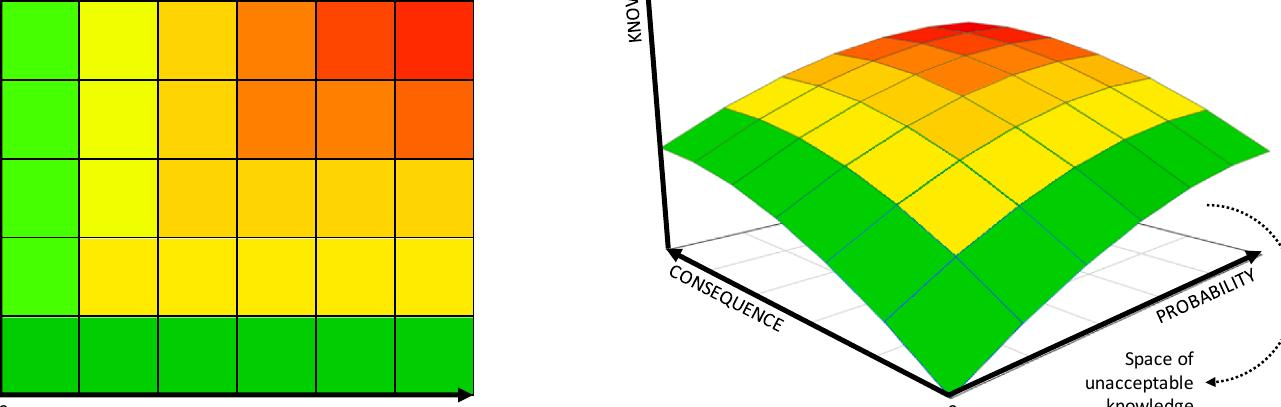

In [45]:
response = chain_with_sources.invoke(
    question
)

print("Response:", response['response'])

print("\n\nContext:")
for text in response['context']['texts']:
    print(text.text)
    print("Page number: ", text.metadata.page_number)
    print("\n" + "-"*50 + "\n")
for image in response['context']['images']:
    display_base64_image(image)

## Query the RAG pipeline. This will return the answer to the question based on the data extracted from the PDF and the LLM knowledge base.

Basic Response:
Based on the Elbow Method graph you provided, the optimal number of clusters (K) for K-Means clustering appears to be **2 or 3**.

Here's why:

*   **Elbow Point:** The "elbow" in the graph represents a point where the rate of decrease in Within-Cluster Sum of Squares (WCSS) starts to diminish significantly. Before the elbow, adding more clusters dramatically reduces WCSS. After the elbow, adding more clusters provides diminishing returns in terms of WCSS reduction.

*   **Visual Inspection:** In the graph, you'll notice a sharp drop in WCSS from K=1 to K=2. The drop is still noticeable from K=2 to K=3, but it becomes less pronounced after that. The point where the curve starts to flatten out resembles an "elbow."

*   **Choosing Between 2 and 3:** Deciding between 2 and 3 would depend on:

    *   The specific context of your data and what you are trying to achieve with clustering.
    *   Further analysis, such as examining the characteristics of the clusters formed w

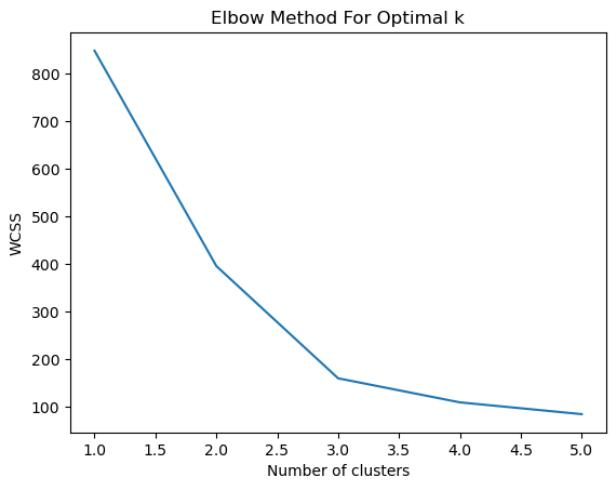


Enhanced Response:
Okay, let's break down how to find the optimal 'k' in the K-Nearest Neighbors (KNN) algorithm. My apologies, the previous response incorrectly addressed K-Means clustering due to a misinterpretation of your initial request. I understand you're interested in KNN, not K-Means.

## Finding the Optimal 'k' in K-Nearest Neighbors (KNN)

**1. Definition of KNN and the Role of 'k'**

K-Nearest Neighbors (KNN) is a supervised machine learning algorithm used for both classification and regression tasks. It works by classifying a new data point based on the majority class (for classification) or the average value (for regression) of its 'k' nearest neighbors in the feature space.

The parameter 'k' represents the number of neighbors considered when making a prediction. Choosing the right 'k' is crucial for the performance of the KNN algorithm.

*   **Small 'k':** Makes the model more sensitive to noise and outliers, potentially leading to overfitting. The decision boundary be

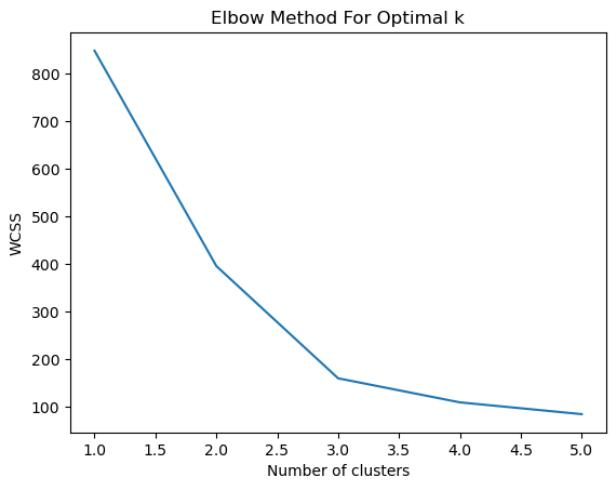

In [ ]:
##run this cell. don't run bottom cells
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from google.generativeai import GenerativeModel

# Define a function to use Gemini model as an enhancer
def gemini_enhancer(prompt_input):
    """Use Gemini 2.0 Flash to enhance RAG responses"""
    # Format the prompt for Gemini
    formatted_prompt = f"""
You are an expert educational assistant helping explain research papers and engineering concepts to users.

Below is information retrieved from my knowledge base about: {prompt_input['question']}

Retrieved information:
{prompt_input['rag_response']}

Please provide a comprehensive answer that:
1. Starts with a clear definition
2. Explains key characteristics and types
3. Provides real-world examples or applications
4. Is written in a professional yet accessible tone
5. Includes any relevant information from your knowledge that wasn't in the retrieved content.
6. Provide equations from the retrieved content if applicable or from your knowledge base. 
7. Please cite sources from the retrieved content if applicable and from your knowledge base.

Your response should be well-structured with appropriate headings.
"""
    
    # Create the Gemini model
    model = GenerativeModel(model_name="gemini-2.0-flash")
    
    # Generate enhanced response
    response = model.generate_content(formatted_prompt)
    return response.text

# Update your main chain to include the Gemini enhancement step
enhanced_chain = RunnableParallel(
    final_response=RunnableParallel({
        "question": RunnablePassthrough(),
        "rag_response": chain,
    }) | RunnableLambda(gemini_enhancer),
    context=retriever | RunnableLambda(parse_docs)  # Keep original context for reference
)

# Use the process_question function to get and display all results
def process_question(question_text):
    """
    Process a question through both chains and display all relevant context
    
    Args:
        question_text (str): The question to process
        
    Returns:
        dict: Contains basic response, enhanced response, and context
    """
    # Set the global question variable if you want to use it elsewhere
    global question
    question = question_text
    
    # Get basic response with sources
    response = chain_with_sources.invoke(question)
    
    # Display basic response
    print("Basic Response:")
    print(response['response'])
    
    # Display context with text and images
    print("\n\nContext:")
    for text in response['context']['texts']:
        print(text.text)
        if hasattr(text, 'metadata'):
            if hasattr(text.metadata, 'page_number'):
                print("Page number:", text.metadata.page_number)
            if hasattr(text.metadata, 'source'):
                print("Source:", text.metadata.source)
        print("\n" + "-"*50 + "\n")
    
    # Display images from context
    print("Context Images:")
    for image in response['context']['images']:
        display_base64_image(image)
    
    # Get enhanced response using the same question
    result = enhanced_chain.invoke(question)
    
    # Display enhanced response
    print("\nEnhanced Response:")
    print(result["final_response"])
    
    # Also display the same context images after the enhanced response
    print("\nContext Images (For Enhanced Response):")
    for image in response['context']['images']:
        display_base64_image(image)
    
    return {
        "basic_response": response['response'],
        "enhanced_response": result["final_response"],
        "context": response['context']
    }

# Example usage with your specific question
result = process_question(question)

In [ ]:
## don't run, only for testing
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from google.generativeai import GenerativeModel

# Define a function to use Gemini model as an enhancer
def gemini_enhancer(prompt_input):
    """Use Gemini 2.0 Flash to enhance RAG responses"""
    # Format the prompt for Gemini
    formatted_prompt = f"""
You are an expert educational assistant helping explain research papers and engineering concepts to users.

Below is information retrieved from my knowledge base about: {prompt_input['question']}

Retrieved information:
{prompt_input['rag_response']}

Please provide a comprehensive answer that:
1. Starts with a clear definition
2. Explains key characteristics and types
3. Provides real-world examples or applications
4. Is written in a professional yet accessible tone
5. Includes any relevant information from your knowledge that wasn't in the retrieved content

Your response should be well-structured with appropriate headings.
"""
    
    # Create the Gemini model
    model = GenerativeModel(model_name="gemini-2.0-flash")
    
    # Generate enhanced response
    response = model.generate_content(formatted_prompt)
    return response.text

# Update your main chain to include the Gemini enhancement step
enhanced_chain = RunnableParallel(
    final_response=RunnableParallel({
        "question": RunnablePassthrough(),
        "rag_response": chain,
    }) | RunnableLambda(gemini_enhancer),
    context=retriever | RunnableLambda(parse_docs)  # Keep original context for reference
)

# Use it
result = enhanced_chain.invoke(question)
print("Enhanced Response:\n", result["final_response"])

Enhanced Response:
 Okay, let's break down the differences between twisted pair and fiber optic cables, two fundamental types of network cabling.

**1. Definitions: The Foundation**

*   **Twisted Pair Cable:** A twisted pair cable is a type of cable made by two insulated copper wires twisted together. This twisting helps reduce electromagnetic interference (EMI) from external sources and crosstalk between the wires themselves. They transmit data using electrical signals.
*   **Fiber Optic Cable:** A fiber optic cable transmits data as pulses of light through thin strands of glass or plastic fibers. These fibers are bundled together and protected by layers of cladding and an outer jacket.

**2. Key Characteristics and Types: Deep Dive**

Let's explore their attributes in detail:

**Twisted Pair Cables:**

*   **Material:** Primarily copper wire.
*   **Signal Type:** Electrical signals.
*   **Speed:** Generally slower than fiber optic. Speeds vary widely based on the category of cable (

Basic Response:
Transmission media is a communication channel that carries information from the sender to the receiver. Data is transmitted through electromagnetic signals. It's a physical path between transmitter and receiver in data communication. In copper-based networks, bits are in the form of electrical signals, and in fiber-based networks, they're in the form of light pulses. Electrical signals can be sent through copper wire, fiber optics, the atmosphere, water, and vacuum.


Context:
HYBRID TOPOLOGY

ADVANTAGES:

Provides flexibility to meet specific requirements and optimize performance.

Offers a balance between cost, scalability, and fault tolerance.

Can leverage the advantages of different topologies while mitigating their disadvantages.

DISADVANTAGES:

Complex to design and implement, requiring careful planning and integration.

Increased cost and potential for conflicts between different topology components.

TRANSMISSION MEDIA

TRANSMISSION MEDIA

Transmission media i

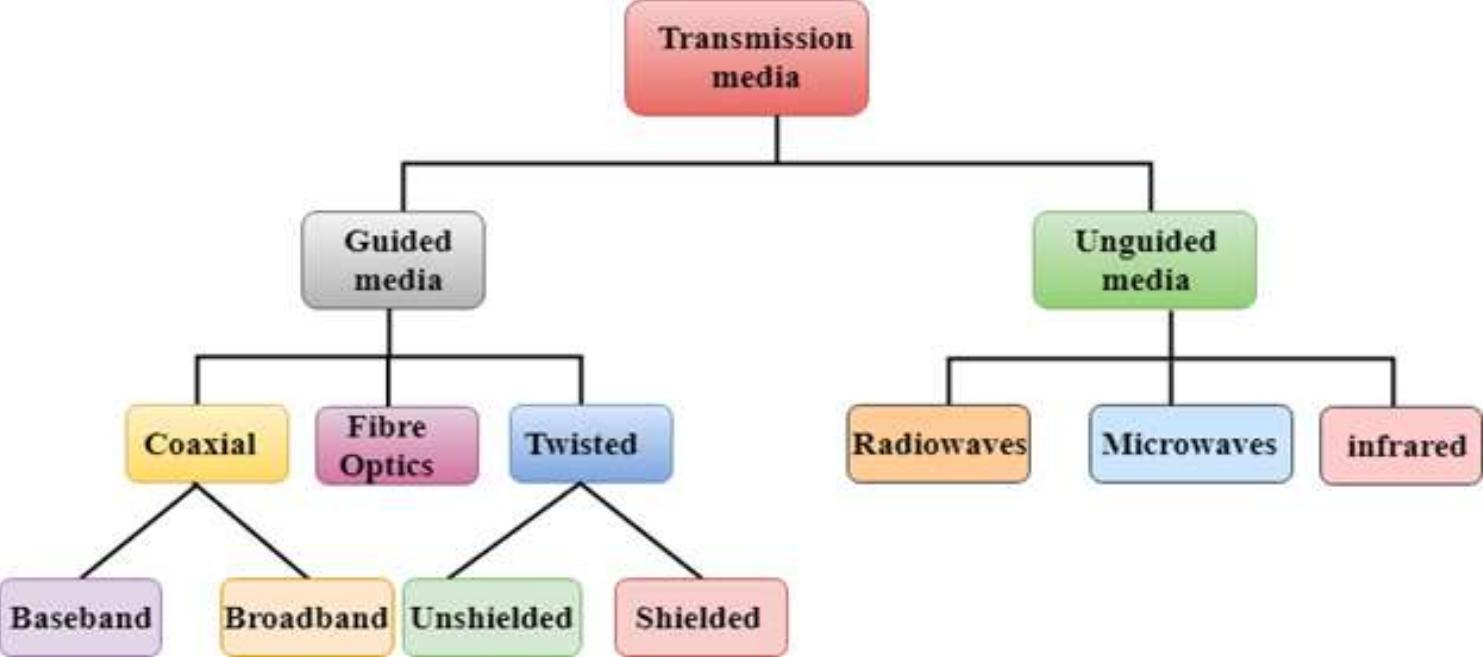


Enhanced Response:
Okay, let's break down the concept of transmission media in computer networking.

**1. Definition: What is Transmission Media?**

Transmission media, in the context of computer networking, is the *physical pathway* through which data travels from a sender to a receiver. Think of it as the highway upon which data packets are transported.  This pathway facilitates communication by carrying information encoded as electromagnetic signals. The key role of transmission media is to provide a reliable and efficient channel for data transfer.

**2. Key Characteristics and Types of Transmission Media**

Transmission media can be broadly classified into two main categories:

*   **Guided Media (Wired):** These media use a physical cable or wire to guide the signal. They offer a more secure and reliable connection compared to unguided media.

    *   **Twisted Pair Cable:** Consists of two insulated copper wires twisted together to reduce interference (noise) and crosstalk. The

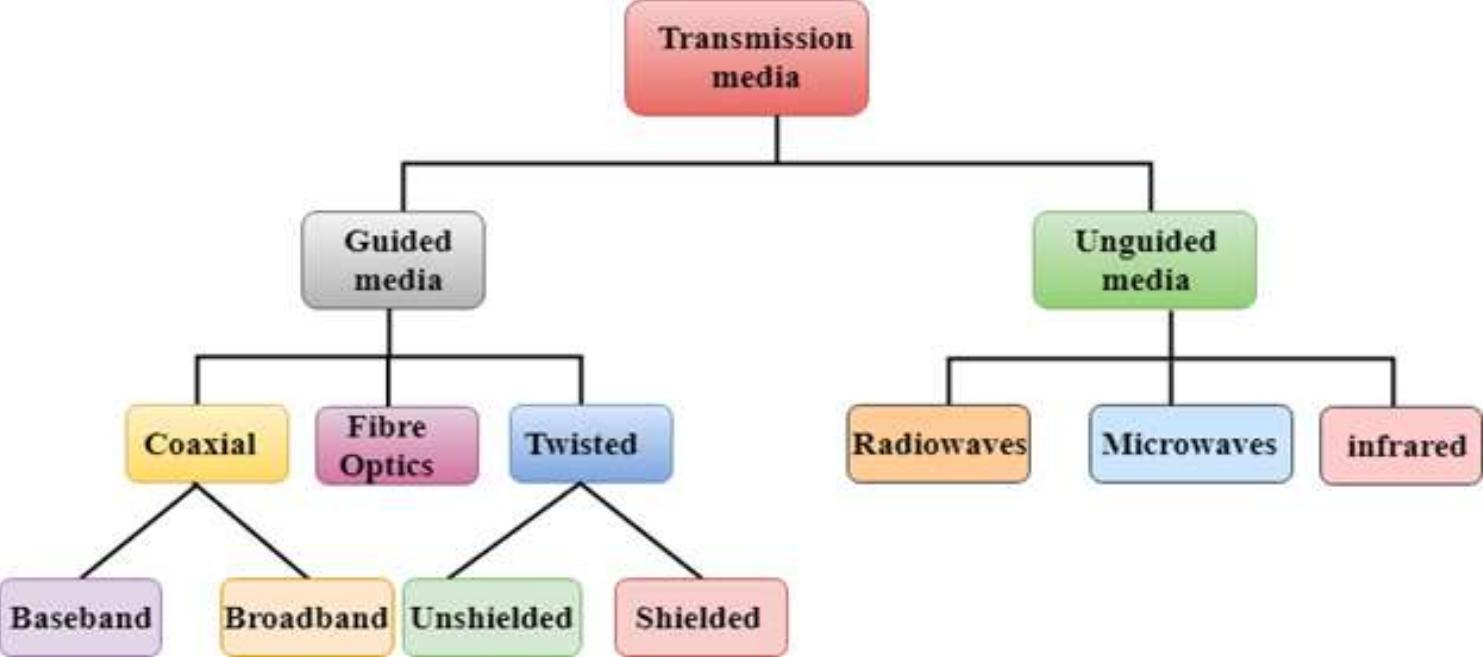

{'basic_response': "Transmission media is a communication channel that carries information from the sender to the receiver. Data is transmitted through electromagnetic signals. It's a physical path between transmitter and receiver in data communication. In copper-based networks, bits are in the form of electrical signals, and in fiber-based networks, they're in the form of light pulses. Electrical signals can be sent through copper wire, fiber optics, the atmosphere, water, and vacuum.",
 'enhanced_response': "Okay, let's break down the concept of transmission media in computer networking.\n\n**1. Definition: What is Transmission Media?**\n\nTransmission media, in the context of computer networking, is the *physical pathway* through which data travels from a sender to a receiver. Think of it as the highway upon which data packets are transported.  This pathway facilitates communication by carrying information encoded as electromagnetic signals. The key role of transmission media is to 

In [ ]:
## don't run, only for testing
def process_question(question_text):
    """
    Process a question through both chains and display all relevant context
    
    Args:
        question_text (str): The question to process
        
    Returns:
        dict: Contains basic response, enhanced response, and context
    """
    # Set the global question variable if you want to use it elsewhere
    global question
    question = question_text
    
    # Get basic response with sources
    response = chain_with_sources.invoke(question)
    
    # Display basic response
    print("Basic Response:")
    print(response['response'])
    
    # Display context with text and images
    print("\n\nContext:")
    for text in response['context']['texts']:
        print(text.text)
        if hasattr(text, 'metadata'):
            if hasattr(text.metadata, 'page_number'):
                print("Page number:", text.metadata.page_number)
            if hasattr(text.metadata, 'source'):
                print("Source:", text.metadata.source)
        print("\n" + "-"*50 + "\n")
    
    # Display images from context
    print("Context Images:")
    for image in response['context']['images']:
        display_base64_image(image)
    
    # Get enhanced response using the same question
    result = enhanced_chain.invoke(question)
    
    # Display enhanced response
    print("\nEnhanced Response:")
    print(result["final_response"])
    
    # Also display the same context images after the enhanced response
    print("\nContext Images (For Enhanced Response):")
    for image in response['context']['images']:
        display_base64_image(image)
    
    return {
        "basic_response": response['response'],
        "enhanced_response": result["final_response"],
        "context": response['context']
    }

# Example usage
process_question("What is transmission media?")